### Подготовительный этап

Обоснование происходящего будет [тут](https://raw.githubusercontent.com/johanDDC/RiemannianOptimizationTT/3af4e53147cd5a89dd53461d22775641cfddcd6e/partial_evp/evp.pdf).

Если вкратце: хочу работать с операторами вида
\begin{align*}
\mathcal{A} \colon \mathbb{R}^{n_1 \times \ldots \times n_d} \to \mathbb{R}^{m_1 \times \ldots \times m_d}
\end{align*}

Такие операторы задаются тензорами, вида $\mathbf{A} \in
\mathbb{R}^{(m_1 \times n_1) \times \ldots \times (m_d \times n_d)}$, и TT-разложения таких
операторов содержат ядра порядка $4$. TTAX в такое не умеет, он работает только с ядрами
порядка $3$. А мне прям жесть как это нужно. В файлике я расписываю оптимальный способ получить
TT-разложение, которое мне нужно, и оптимальный способ умножить такой оператор на тензор.


In [4]:
import jax
import jax.numpy as jnp
import numpy as np
from numpy import random
import ttax
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def apply_operator(operator_tt : ttax.base_class.TTMatrix, vec_tt : ttax.base_class.TT):
    return ttax.base_class.TT([
        jnp.einsum('abic,eig->aebcg', operator_tt.tt_cores[i], vec_tt.tt_cores[i]).reshape((
            operator_tt.tt_cores[i].shape[0] * vec_tt.tt_ranks[i], operator_tt.tt_cores[i].shape[1],
            operator_tt.tt_cores[i].shape[3] * vec_tt.tt_ranks[i + 1]), order="F",
        )
        for i in range(len(vec_tt.tt_cores))
    ])

jited_aplly_operator = jax.jit(apply_operator)

@jax.jit
def transpose(operator_tt : ttax.base_class.TTMatrix):
  cores = [jnp.einsum('aijb->ajib', operator_tt.tt_cores[i])
             for i in range(len(operator_tt.tt_cores))]
  return ttax.base_class.TTMatrix(cores)

Простой тест: есть оператор $\mathbb{R}^{3\times2} \to \mathbb{R}^{2\times2}$, и случайный
тензор из $\mathbb{R}^{3\times2}$. Мы ожидаем, что результом применение оператора к
тензору будет тензор из $\mathbb{R}^{2\times2}$:

In [6]:
# simple test: we have an operator from R^{3x2} to R^{2x2} and random tensor from R^{3x2}
# we expect, that result of applying operator to tensor will be tensor from R^{2x2}
modes = ((2, 2), (3, 2))
# modes = M x N
TT_op = ttax.random.matrix(jax.random.PRNGKey(42), modes)
TT_el = ttax.random.tensor(jax.random.PRNGKey(42), (3, 2))
print("operator shape is", TT_op.shape)
print("source tensor shape is", TT_el.shape)
print("target tensor shape is", apply_operator(TT_op, TT_el).shape)

operator shape is (4, 6)
source tensor shape is (3, 2)
target tensor shape is (2, 2)


### Основной этап

Тестировать будем на симметричных операторах такого вида: если $\mathbf{A}$ — случайный оператор,
тогда оператор $\mathbf{A} + \mathbf{A}^T$ — симметричный.

**Проблема**: оператор для нас, это коллекция TT ядер порядка $4$, от которых ожидается только умение
каким-то образом умножаться на тензор из source пространства. Соответственно, складывать
операторы мы не умеем, поэтому не сможем сделать операцию
$(\mathbf{A} + \mathbf{A}^T)x$. Зато мы сможем сделать $(\mathbf{A}x) + (\mathbf{A}^Tx)$,
так как результатом умножения оператора на тензор является объект класса
ttax.base_class.TT. По этой причине в коде ниже будем представлять операторы, как
функции, принимающие тензор, на который надо умножить оператор.

In [7]:
make_rayleigh = lambda A: lambda x: ttax.flat_inner(x, A(x))
norm = lambda x: jnp.sqrt(ttax.flat_inner(ttax.orthogonalize(x), ttax.orthogonalize(x)))
fused_norm = jax.jit(norm)
residual = lambda A, x, eig: fused_norm(A(x) + (-eig) * x) / fused_norm(A(x))

def retraction(T, rk):
    res = ttax.round(T, max_tt_rank=rk)
    res = ttax.orthogonalize(res * (1.0/fused_norm(res)))
    # res = res * (1.0/fused_norm(res))
    return res

a = []

def armijo_backtracking(init, grad, rk, mul, beta, func, x):
    alpha = init
    iters = 0
    optimal_x = retraction(x + (-alpha) * grad, rk)
    while func(x) - func(optimal_x) < mul * alpha * fused_norm(grad) ** 2:
        alpha *= beta
        iters += 1
        optimal_x = retraction(x + (-alpha) * grad, rk)
        if iters > 40:
            break
    a.append(iters)
    return optimal_x

В процессе тестирования возникала проблема: алгоритм на очередной итерации заходил в
Армихо, и больше не выходил оттуда. Чтобы избежать такой ситуации, мы будем принудительно
выходить из цикла после некоторого числа итераций. Кроме того я добавил ещё одну модификацию:
во время тестирования часто бывало такое, что из-за небольшой длины шага Армихо мы несколько
итераций подряд должны были идти в одном направлении. Я модифицировал алгоритм таким образом,
что если мы практически не продвинулись за последние две итерации, то имеет смысл шагнуть
сразу на большое расстояние, и потом, если что, вернуться уже силами алгоритма. Тестирование
показало, что идея была здравая.

In [8]:
def riemanGD(A, init, tol, rk, max_iter = None, debug = False):
    rayleigh = make_rayleigh(A)
    # fused_rayleigh = ttax.fuse(rayleigh)
    rieman_grad = ttax.autodiff.grad(rayleigh)
    x = retraction(init, rk)
    residuals = [residual(A, x, rayleigh(x))]
    iters = 0
    if debug == True:
        print("№\tresidual")
    while residual(A, x, rayleigh(x)) > tol:
        rieman_x = rieman_grad(x)
        # optimum = ttax.flat_inner(x, A(rieman_x)) / ttax.flat_inner(rieman_x, A(rieman_x))
        if len(residuals) >= 2 and (residuals[-1] / residuals[-2] < 0.99):
            # print("BOOM", residuals[-1] / residuals[-2])
            x = retraction(x + (-250) * rieman_x, rk)
        else:
            x = armijo_backtracking(1, rieman_x, rk, 1E-4, 0.5, rayleigh, x)
            # x = armijo_backtracking(optimum, rieman_x, rk, 1E-4, 0.5, rayleigh, x)
        iters += 1
        residuals.append(residual(A, x, rayleigh(x)))
        if debug == True:
            print("{}\t{}".format(iters, residual(A, x, rayleigh(x))))
        if (max_iter is not None and iters >= max_iter):
            break

    return x, residuals

In [9]:
def test(count, rk, size, iters, debug=False):
    graphs = []
    for i in range(count):
        modes_t = [rk] * size
        modes_op = (modes_t, modes_t)
        A = ttax.random.matrix(jax.random.PRNGKey(random.randint(1, 100)), modes_op)
        AT = transpose(A)
        def sym(x : ttax.base_class.TT):
          return jited_aplly_operator(A, x) + jited_aplly_operator(AT, x)
        t = ttax.random.tensor(jax.random.PRNGKey(42), modes_t, tt_rank=rk)
        v, rs = riemanGD(sym, t, 4E-4, rk, iters, debug)
        graphs.append(plt.plot(rs))

    plt.xlabel("Iteration")
    plt.ylabel("Residual")
    plt.semilogy()
    plt.show(graphs)

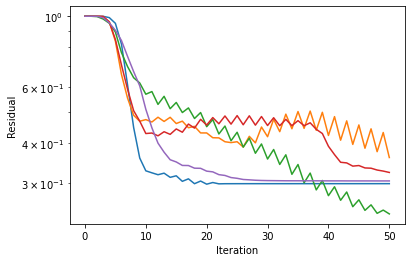

In [10]:
test(5, 3, 16, 50)

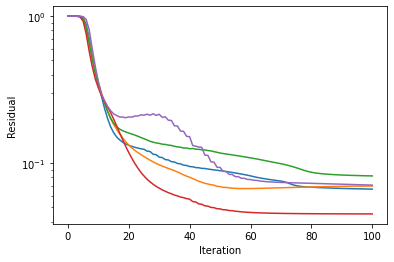

In [11]:
test(5, 10, 16, 100)

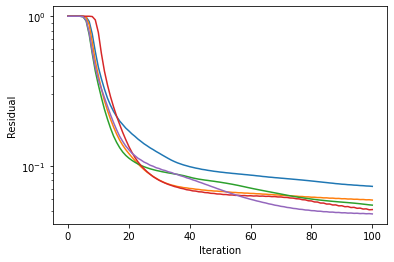

In [12]:
test(5, 15, 16, 100)

In [13]:
max(a)

41